In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

count_n = 500 * 8
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [28]:
import cv2
import copy
from os import listdir
from pathlib import Path
from os.path import isfile, join
from tqdm import tqdm
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

In [29]:
#create random places to remove the file pixels to simulate compressed sensing
def create(pp, img):
    img_ = np.zeros((8, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

    for i in range(len(img)):
        mask = np.random.choice([0, 1], size=(IMG_HEIGHT, IMG_WIDTH), p=[1-pp, pp])
        idx_w, idx_h = np.where(mask ==  1)

        for j in range(len(idx_w)):
            img[i, idx_w[j],idx_h[j],0] = 0

        img_[i,:,:,0] = img[i,:,:,0]
    return img_
def create_(pp, img):
    img_ = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

    for i in range(len(img)):
        mask = np.random.choice([0, 1], size=(IMG_HEIGHT, IMG_WIDTH), p=[1-pp, pp])
        idx_w, idx_h = np.where(mask ==  1)

        for j in range(len(idx_w)):
            img[i, idx_w[j],idx_h[j],0] = 0
            
        img_[i,:,:,0] = img[i,:,:,0]
    return img_

In [4]:
#extract the images from the dataset
def curate(X_train, Y_train):
    data = Path('/content/drive/MyDrive/Datasets/csDataset/images')
    lst = [x for x in data.iterdir() if data.is_dir()]
    cnt = 0
  
    for idx, j in tqdm(enumerate(lst)):
        onlyfiles   = [f for f in listdir(lst[idx]) if isfile(join(lst[idx], f))]
        onlyfiles.remove('Thumbs.db')

        for _, i in enumerate(onlyfiles):
            p = join(str(lst[idx]),i)
            img = cv2.imread(p, 0)
            y_patches = image.extract_patches_2d(img, (IMG_HEIGHT, IMG_WIDTH), max_patches = 8)

            y_patches = np.reshape(y_patches,(8, IMG_HEIGHT, IMG_WIDTH,-1))


            y_patch = copy.deepcopy(y_patches)
            x_patches = create(0.50, y_patch)
            #print(x_patches.shape)
            for k in range(len(x_patches)):
                X_train[cnt] = x_patches[k]
                Y_train[cnt] = y_patches[k]
                cnt += 1

    return X_train, Y_train

In [ ]:
def curate_new(X_train, Y_train):
  data = Path('/content/drive/MyDrive/Datasets/csDataset/Linnaeus256by256/train')
  lst = [x for x in data.iterdir() if data.is_dir()]
  cnt = 0

  for idx, j in tqdm(enumerate(lst)):
    onlyfiles   = [f for f in listdir(lst[idx]) if isfile(join(lst[idx], f))]
    
    for _, i in enumerate(onlyfiles):
      p = join(str(lst[idx]),i)
      img = cv2.imread(p, 0)
      y_patches = image.extract_patches_2d(img, (IMG_HEIGHT, IMG_WIDTH), max_patches = 2)

      y_patches = np.reshape(y_patches,(2, IMG_HEIGHT, IMG_WIDTH,-1))


      y_patch = copy.deepcopy(y_patches)
      x_patches = create_(0.50, y_patch)
      
      for k in range(len(x_patches)):
        X_train[cnt] = x_patches[k]
        Y_train[cnt] = y_patches[k]
        cnt += 1

  return X_train, Y_train

count_n_ = 6000 * 2

#create dataset for images
########################## CREATE DATASET #############################
X_train_ = np.zeros((count_n_, 128, 128, 1), dtype=np.uint8)
Y_train_ = np.zeros((count_n_, 128, 128, 1), dtype=np.uint8)
#######################################################################

X_, Y_ = curate_new(X_train_, Y_train_)






0it [00:00, ?it/s]




1it [00:13, 13.24s/it]

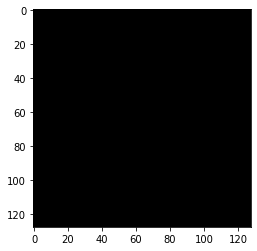

In [26]:
plt.imshow(np.reshape(Y_[2400,:,:,:],(128,128)),cmap='gray')
plt.show()

In [11]:
X_.shape

(12000, 128, 128, 1)

In [6]:
#print the images for testing
def printResult(X, Y):
    fig = plt.figure(figsize=(9, 4))
    columns = 10
    rows = 1
    for i in range(1, columns*rows + 1):
        img_x = X[i-1]
        ax = fig.add_subplot(rows, columns, i)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img_x, cmap = 'gray')
    plt.show()
    return None

In [7]:
def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def networkCSNet(x_train, y_train, x_val, y_val):

    input_layer = tf.keras.layers.Input((128, 128, 1))

    conv1 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(input_layer)
    #conv1 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv1)
    #conv2 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv2)
    #conv3 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    conv4 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv3)
    #conv4 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)

    conv5 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv4)
    #conv5 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv5)
    conv5 = tf.keras.layers.ReLU()(conv5)
    
    conv6_1 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv5)
    #conv6 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv6)
    conv6_1 = tf.keras.layers.ReLU()(conv6_1)

    '''
    conv7 = tf.keras.layers.Conv2D(1, (5,5), padding='same')(conv6)
    #conv6 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv6)
    conv7 = tf.keras.layers.ReLU()(conv7)

    conv8 = tf.keras.layers.Conv2D(1, (5,5), padding='same')(conv7)
    #conv6 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv6)
    conv8 = tf.keras.layers.ReLU()(conv8)
    
    conv9 = tf.keras.layers.Conv2D(1, (5,5), padding='same')(conv8)
    #conv6 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv6)
    conv9 = tf.keras.layers.ReLU()(conv9)
    '''
    output_layer = tf.keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(conv6_1)

    ae = tf.keras.models.Model(inputs = [input_layer], outputs = [output_layer])
    ae.compile(optimizer='adam', loss=ssim_loss)

    ae.summary()
    checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Datasets/csDataset/results/cs-unet-500.h5', verbose=1, save_best_only=True)
    history = ae.fit(x_train, y_train, epochs=300, batch_size=8, shuffle=True, validation_data=(x_val, y_val), verbose = 1,  callbacks=[checkpointer])

    hist_df = pd.DataFrame(history.history)
    hist_csv_file = '/content/drive/MyDrive/Datasets/csDataset/results/cs-unet-history-500.csv'

    with open(hist_csv_file, mode = 'w') as f:
        hist_df.to_csv(f)

    print('End of training ...')
    return ae

In [8]:
def networkCSNet_unet(x_train, y_train, x_val, y_val):

    input_layer = tf.keras.layers.Input((128, 128, 1))

    conv1 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(input_layer)
    #conv1 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv1)
    #conv2 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv2)
    #conv3 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    conv4 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv3)
    #conv4 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)

    conv5 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv4)
    #conv5 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv5)
    conv5 = tf.keras.layers.ReLU()(conv5)
    
    conv6 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv5)
    #conv6 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv6)
    conv6 = tf.keras.layers.ReLU()(conv6)

    
    conv7 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv6)
    #conv6 = tf.keras.layers.Conv2D(1, (3,3), padding='same')(conv6)
    conv7 = tf.keras.layers.ReLU()(conv7)

    output_layer = tf.keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(conv7)

    ae = tf.keras.models.Model(inputs = [input_layer], outputs = [output_layer])
    ae.compile(optimizer='adam', loss=ssim_loss)

    ae.summary()
    checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Datasets/csDataset/results/cs-unet-500.h5', verbose=1, save_best_only=True)
    history = ae.fit(x_train, y_train, epochs=300, batch_size=8, shuffle=True, validation_data=(x_val, y_val), verbose = 1,  callbacks=[checkpointer])

    hist_df = pd.DataFrame(history.history)
    hist_csv_file = '/content/drive/MyDrive/Datasets/csDataset/results/cs-unet-history-500.csv'

    with open(hist_csv_file, mode = 'w') as f:
        hist_df.to_csv(f)

    print('End of training ...')
    return ae

In [9]:
#create dataset for images
########################## CREATE DATASET #############################
X_train = np.zeros((count_n, 128, 128, 1), dtype=np.uint8)
Y_train = np.zeros((count_n, 128, 128, 1), dtype=np.uint8)
#######################################################################
#Get the curated data from the dataset
X, Y = curate(X_train, Y_train)

X = X / 255
Y = Y / 255

3it [00:17,  5.72s/it]


In [10]:
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(X, Y, test_size = 0.2, random_state = 42)
model_cnn = networkCSNet(X_TRAIN, Y_TRAIN, X_VAL, Y_VAL)
predict = model_cnn.predict(X_VAL[:10,:,:,:])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 3)       30        
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 3)       84        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 3)       84        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128, 128, 3)       0     

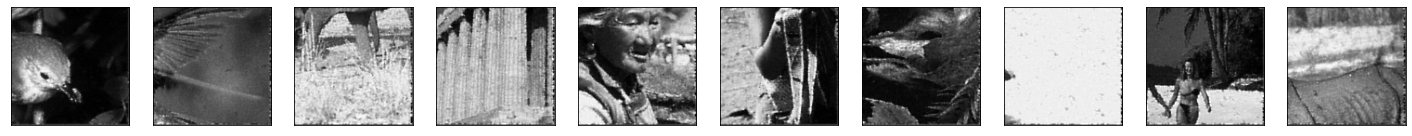

In [11]:
predict = model_cnn.predict(X_VAL[:10,:,:,:])
fig = plt.figure(figsize=(25, 25))
columns = 10
rows = 1
for i in range(1, columns*rows + 1):
  img_x = predict[i-1]
  ax = fig.add_subplot(rows, columns, i)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.reshape(img_x,(128,128)),cmap='gray')
plt.show()

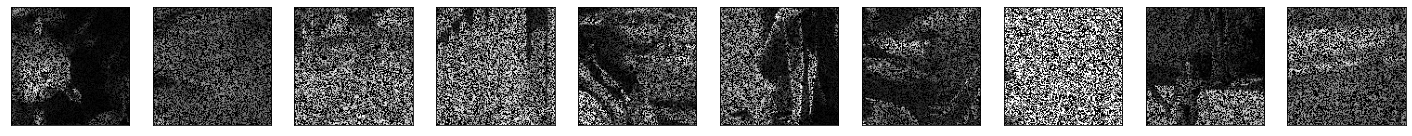

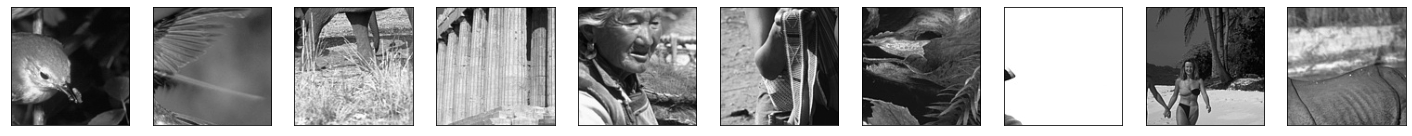

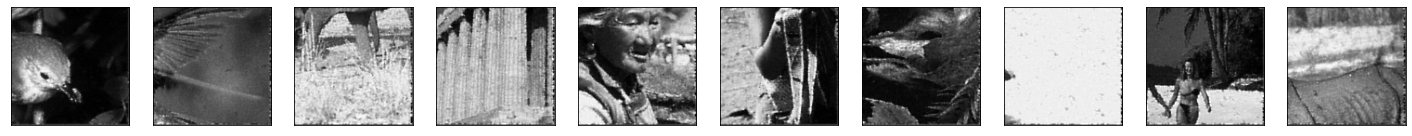

In [12]:
#predict = model_cnn.predict(X_VAL[:10,:,:,:])
predict_x = X_VAL[:10,:,:,:]
predict_y = Y_VAL[:10,:,:,:]
fig = plt.figure(figsize=(25, 25))
columns = 10
rows = 1
for i in range(1, columns*rows + 1):
  img_x = predict_x[i-1]
  ax = fig.add_subplot(rows, columns, i)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.reshape(img_x,(128,128)),cmap='gray')
plt.show()

fig = plt.figure(figsize=(25, 25))
for i in range(1, columns*rows + 1):
  img_x = predict_y[i-1]
  ax = fig.add_subplot(rows, columns, i)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.reshape(img_x,(128,128)),cmap='gray')
plt.show()

predict = model_cnn.predict(X_VAL[:10,:,:,:])
fig = plt.figure(figsize=(25, 25))
columns = 10
rows = 1
for i in range(1, columns*rows + 1):
  img_x = predict[i-1]
  ax = fig.add_subplot(rows, columns, i)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.reshape(img_x,(128,128)),cmap='gray')
plt.show()

In [13]:
psnr2 = tf.image.psnr(Y_VAL[:10,:,:,:], predict, max_val=1.0)
print(psnr2)

tf.Tensor(
[26.046661 30.234768 22.177546 23.545687 23.334877 23.710703 28.068596
 18.782314 23.27435  27.966864], shape=(10,), dtype=float32)


In [14]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Datasets/csDataset/results/cs-unet-history-500.csv', sep=',',header=None)

In [15]:
df.head()
loss = df[1]
val_loss = df[2]

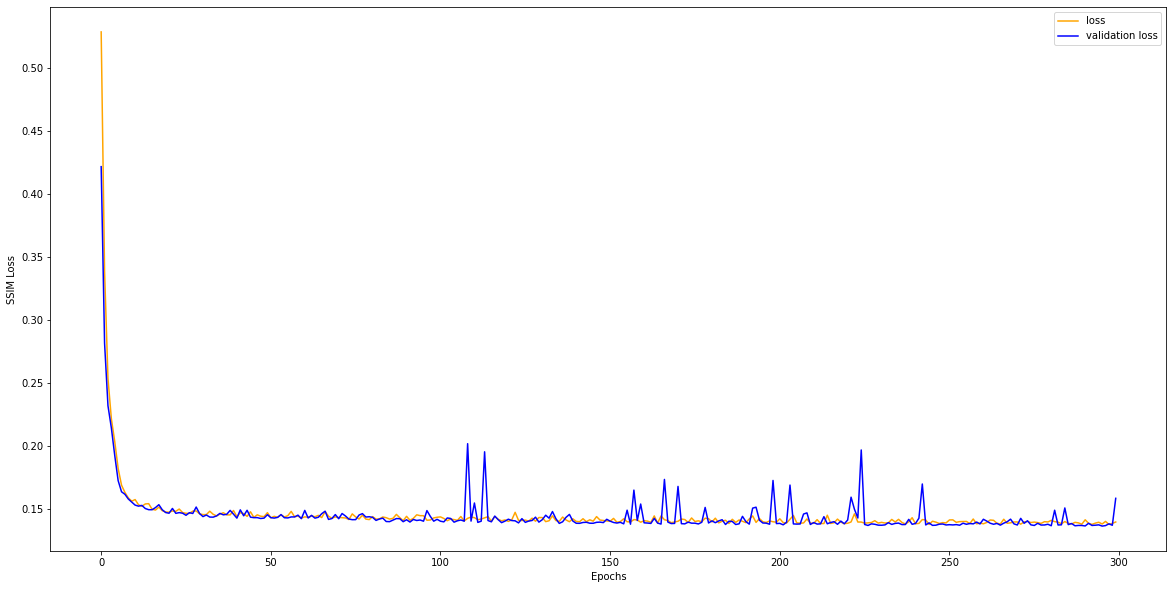

In [17]:
plt.figure(figsize=(20,10))
plt.plot(loss.values[1:].astype(np.float32),color='orange')
plt.plot(val_loss.values[1:].astype(np.float32),color='blue')
plt.legend(['loss','validation loss'])
plt.xlabel('Epochs')
plt.ylabel('SSIM Loss')
plt.show()